In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/foodpoisoningclaims/food_claims_2212.csv


In [2]:
df = pd.read_csv('/kaggle/input/foodpoisoningclaims/food_claims_2212.csv')

Here is a table provided that describes what we expect from our columns and the data stored within:

| Field Name           | Description                                                                                                                                                  |
|----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|
| claim_id             | Nominal. The unique identifier of the claim. Missing values are not possible due to the database structure.                                                  |
| time_to_close        | Discrete. The number of days to close the claim. Any positive value. Replace missing values with the overall median time to close.                           |
| claim_amount         | Continuous. The initial claim requested in the currency of Brazil, rounded to 2 decimal places. Replace missing values with the overall median claim amount. |
| amount_paid          | Continuous. Final amount paid. In the currency of Brazil. Rounded to 2 decimal places. Replace missing values with the overall median amount paid.           |
| location             | Nominal. Location of the claim, one of “RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”. Remove missing values.                                                 |
| individuals_on_claim | Discrete. Number of individuals on this claim. Minimum 1 person. Replace missing value with 0.                                                               |
| linked_cases         | Nominal. Whether this claim is linked to other cases. Either TRUE or FALSE. Replace missing values with FALSE.                                               |
| cause                | Nominal. Cause of the food poisoning. One of “vegetable”, “meat” or “unknown”. Replace missing values with ‘unknown’.                                        |

# 1. For every column in the data:
### a. State whether the values match the description given in the table above.
### b. State the number of missing values in the column.
### c. Describe what you did to make values match the description if they did not match.

Let's use a table to track issues with our columns.

| Field Name           | Issue |
|----------------------|-------|
| claim_id             |       |
| time_to_close        |       |
| claim_amount         |       |
| amount_paid          |       |
| location             |       |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

First, we expect that **claim_id** will be:
* Nominal
* Unique

In [3]:
print("Are there any null values? ", df['claim_id'].isna().any())
print("Is there any duplicated data? ", df['claim_id'].duplicated().any())

Are there any null values?  False
Is there any duplicated data?  False


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |       |
| claim_amount         |       |
| amount_paid          |       |
| location             |       |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

We expect **time_to_close** to be:
* Discrete.
* Any positive value.

In [4]:
column = 'time_to_close'
print("How many null values? ", df[column].isna().sum())
print("What is the lowest value? ", df[column].min())
print("What is the data type? ", df[column].dtype)

How many null values?  0
What is the lowest value?  76
What is the data type?  int64


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |       |
| amount_paid          |       |
| location             |       |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

We expect **claim_amount** to be:
* Continuous. 
* The initial claim requested in the currency of Brazil, rounded to 2 decimal places.

In [5]:
column = 'claim_amount'
print("How many null values? ", df[column].isna().sum())
print("What is the lowest value? ", df[column].min())
print("What is the data type? ", df[column].dtype)

How many null values?  0
What is the lowest value?  R$ 10003.79
What is the data type?  object


We see an issue, we want claim_amount to be saved as a numeric field instead of a string. 

Ideally, I would cut off the text on the left, multiply the number by 100, and save the field as an *integer* representing the value in Brazilian **Centavos** instead of **Real** to avoid any rounding issues.

However, our table requires us to save these as a decimal rounded to two places. To do so, we'll slice out the text on the left and use the *float* dtype.

In [6]:
df['claim_amount'] = df['claim_amount'].str.slice(3).astype(float).round(2)

Now we've got **claim_amount** the way we expected it.

| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, Converted Data Type to Float, & Rounded|
| amount_paid          |       |
| location             |       |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

We expect **amount_paid** to be:
* Continuous.
* Final amount paid.
* In the currency of Brazil.
* Rounded to 2 decimal places.

In [7]:
column = 'amount_paid'
print("How many null values? ", df[column].isna().sum())
print("What is the lowest value? ", df[column].min())
print("What is the data type? ", df[column].dtype)

How many null values?  36
What is the lowest value?  1516.72
What is the data type?  float64


It looks like we have null values. Let's replace these null values with the median amount_paid.

In [8]:
median_amount_paid = df['amount_paid'].median()
print('Median amount_paid is: ', median_amount_paid)
df.fillna({"amount_paid": median_amount_paid},inplace=True)
print("How many null values? ", df[column].isna().sum())

Median amount_paid is:  20105.699999999997
How many null values?  0


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, Converted Data Type to Float, & Rounded|
| amount_paid          |36 Nulls|
| location             |       |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

We expect **location** to be:
* Nominal. 
* Location of the claim
* Either “RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”.

In [9]:
column = 'location'
print("How many null values? ", df[column].isna().sum())
print("What is the data type? ", df[column].dtype)
print('What are the unique values? ',df[column].unique())

How many null values?  0
What is the data type?  object
What are the unique values?  ['RECIFE' 'FORTALEZA' 'SAO LUIS' 'NATAL']


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, Converted Data Type to Float, & Rounded|
| amount_paid          |36 Nulls  |
| location             |NONE   |
| individuals_on_claim |       |
| linked_cases         |       |
| cause                |       |

We expect **individuals_on_claim** to be:
* Discrete.
* Number of individuals on this claim. 
* Minimum 1 person.

In [10]:
column = 'individuals_on_claim'
print("Are there any null values? ", df[column].isna().any())
print("What is the data type? ", df[column].dtype)
print("What is the lowest value? ", df[column].min())

Are there any null values?  False
What is the data type?  int64
What is the lowest value?  1


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, Converted Data Type to Float, & Rounded|
| amount_paid          |36 Nulls  |
| location             |NONE   |
| individuals_on_claim |NONE   |
| linked_cases         |       |
| cause                |       |

We expect **linked_cases** to be:
* Nominal.
* Whether this claim is linked to other cases.
* Either TRUE or FALSE.

In [11]:
column = 'linked_cases'
print("How many null values? ", df[column].isna().sum())
print("What is the data type? ", df[column].dtype)

How many null values?  26
What is the data type?  object


I see that there are nulls in **linked_cases**. This is probably why the data type is not listed as *bool* Let's replace null values with False.

In [12]:
df.fillna({"linked_cases": False},inplace=True)

print("How many null values? ", df[column].isna().sum())
print("What is the data type? ", df[column].dtype)

How many null values?  0
What is the data type?  bool


| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, Converted Data Type to Float, & Rounded|
| amount_paid          |36 Nulls  |
| location             |NONE   |
| individuals_on_claim |NONE   |
| linked_cases         |26 Nulls, Saved as Object instead of bool |
| cause                |       |

We expect **cause** to be:
* Nominal. 
* Cause of the food poisoning. 
* One of “vegetable”, “meat” or “unknown”.

In [13]:
column = 'cause'
print("Are there any null values? ", df[column].isna().any())
print("What is the data type? ", df[column].dtype)
print('What are the unique values? ',df[column].unique())

Are there any null values?  False
What is the data type?  object
What are the unique values?  ['unknown' 'meat' 'vegetable' ' Meat' 'VEGETABLES']


I see an issue - there are different capitalizations for these values. We need to replace
* ' Meat' with 'meat'
* 'VEGETABLES' with 'vegetable'.

In [14]:
df['cause'].replace(' Meat','meat',inplace=True)
df['cause'].replace('VEGETABLES','vegetable',inplace=True)
print('What are the unique values? ',df['cause'].unique())

What are the unique values?  ['unknown' 'meat' 'vegetable']


At this point, we've reviewed all the columns and identified a few with issues that we resolved:

| Field Name           | Issue |
|----------------------|-------|
| claim_id             |NONE   |
| time_to_close        |NONE   |
| claim_amount         |Sliced, converted type to float, & rounded|
| amount_paid          |36 Nulls  |
| location             |NONE   |
| individuals_on_claim |NONE   |
| linked_cases         |26 Nulls, Saved as Object instead of bool |
| cause                |Replaced typo values|

We now have a version of our data with accurate values, completing task **1**.

---
# 2. Create a visualization that shows the number of claims in each location. Use the visualization to:
### a. State which category of the variable location has the most observations
### b. Explain whether the observations are balanced across categories of the variable location

To begin, let's identify which location has the most claim IDs. To so, we will group by **location** and count the results.

In [15]:
df.groupby('location')['time_to_close'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
FORTALEZA,311.0,185.305466,47.583000,76.0,157.0,180.0,205.5,453.0
NATAL,287.0,185.926829,47.059160,93.0,157.0,179.0,205.5,361.0
RECIFE,885.0,184.607910,48.013254,82.0,157.0,178.0,203.0,427.0
SAO LUIS,517.0,187.170213,53.126094,84.0,161.0,179.0,205.0,518.0


Judging from our results, **RECIFE** has the most observations, **885**.

|  location | count |       mean |       std |  min |   25% |   50% |   75% |   max |
|----------:|------:|-----------:|----------:|-----:|------:|------:|------:|------:|
| FORTALEZA | 311.0 | 185.305466 | 47.583000 | 76.0 | 157.0 | 180.0 | 205.5 | 453.0 |
|     NATAL | 287.0 | 185.926829 | 47.059160 | 93.0 | 157.0 | 179.0 | 205.5 | 361.0 |
|    **RECIFE** | **885.0** | 184.607910 | 48.013254 | 82.0 | 157.0 | 178.0 | 203.0 | 427.0 |
|  SAO LUIS | 517.0 | 187.170213 | 53.126094 | 84.0 | 161.0 | 179.0 | 205.0 | 518.0 |

<Axes: xlabel='location', ylabel='count'>

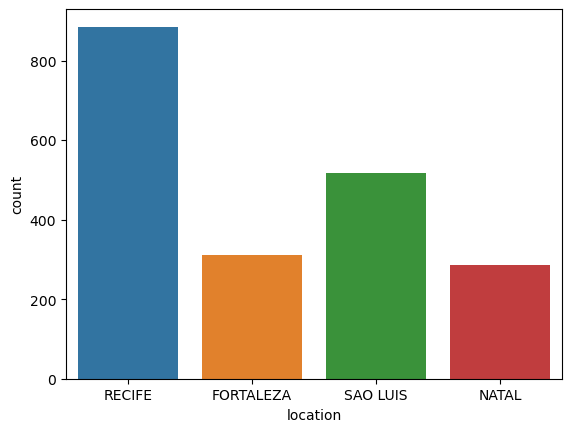

In [16]:
sns.countplot(x = df['location'])

By examining the location chart, it also seems like there is a **disporportionately large** number of cases being sent to the RECIFE location.

---
# 3. Describe the distribution of time to close for all claims. Your answer must include a visualization that shows the distribution.

To look at our overall distribution of time_to_close, we'll build a univariate histogram.

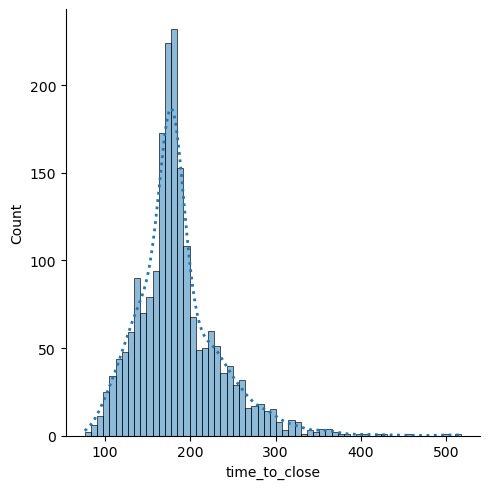

In [17]:
ax = sns.displot(df, x="time_to_close", kde=True, line_kws={ 'lw': 2, 'ls': ':'})

In [18]:
df['time_to_close'].describe()

count    2000.00000
mean      185.56800
std        49.16339
min        76.00000
25%       158.00000
50%       179.00000
75%       204.00000
max       518.00000
Name: time_to_close, dtype: float64

Our histogram shows a:
* **unimodal** distribution 
* **skewed right**
* with a minimum of **76**
* maximum of **518**
* a peak around **185**

---
# 4. Describe the relationship between time to close and location. Your answer must include a visualization to demonstrate the relationship.

<Axes: xlabel='time_to_close', ylabel='location'>

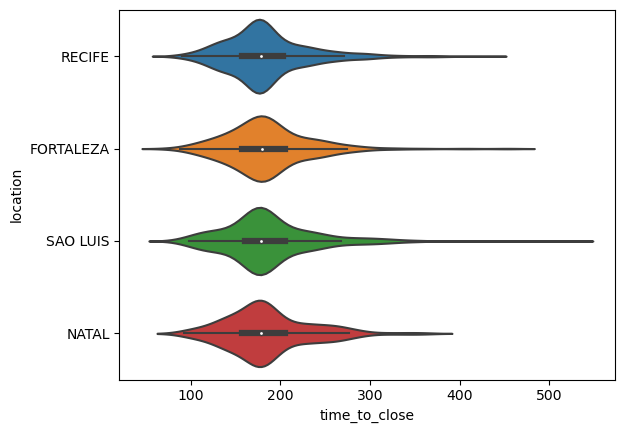

In [19]:
sns.violinplot(x=df['time_to_close'], y=df['location'])

<Axes: xlabel='time_to_close', ylabel='location'>

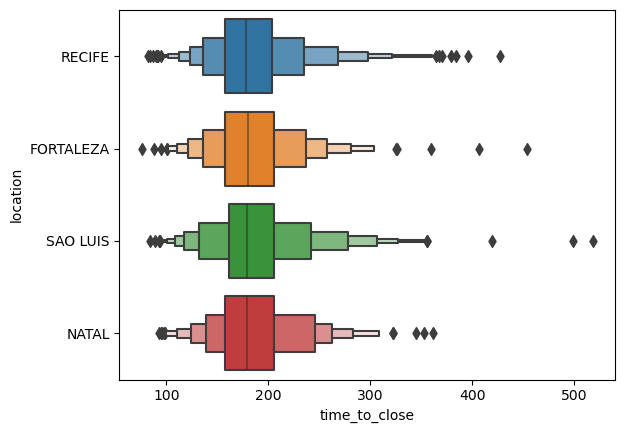

In [20]:
sns.boxenplot(data = df, x='time_to_close', y='location')